Using device: cuda
GPU: Tesla P100-PCIE-16GB
GPU Memory: 17.06 GB

LOADING MEMMAP DATASET
Total tokens: 1,202,932,080
Train tokens: 1,082,638,872
Val tokens:   120,293,208
Vocab size:   50257

INITIALIZING MODEL
Parameters: 70.63M
Approx model size (fp32): 282.54 MB
tok_emb.weight (50257, 512)
pos_emb.weight (512, 512)
blocks.0.ln1.weight (512,)
blocks.0.ln2.weight (512,)
blocks.0.attn.c_attn.weight (1536, 512)
blocks.0.attn.c_attn.bias (1536,)
blocks.0.attn.c_proj.weight (512, 512)
blocks.0.attn.c_proj.bias (512,)
blocks.0.ff.net.0.weight (2048, 512)
blocks.0.ff.net.0.bias (2048,)


/tmp/ipykernel_19/1487200677.py:289: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if (use_amp and device.type == "cuda") else None
/tmp/ipykernel_19/1487200677.py:252: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with ctx():


✅ Checkpoints dir: /kaggle/working/checkpoints
✅ Plots dir: /kaggle/working/plots
✅ Logs dir: /kaggle/working/logs

STARTING TRAINING
Step     0 | Train 10.9172 | Val 10.9168 | PPL 55096.66 | LR 0.00e+00 | Elapsed  0.00h | ETA 221.23h ⭐ BEST


/tmp/ipykernel_19/1487200677.py:369: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with ctx():


Step   500 | Train 6.0897 | Val 6.1822 | PPL   484.07 | LR 3.00e-04 | Elapsed  0.07h | ETA 10.32h ⭐ BEST
Step  1000 | Train 5.6534 | Val 5.7258 | PPL   306.68 | LR 6.00e-04 | Elapsed  0.14h | ETA  9.99h ⭐ BEST
Step  1500 | Train 5.3559 | Val 5.3676 | PPL   214.35 | LR 6.00e-04 | Elapsed  0.20h | ETA  9.81h ⭐ BEST
Step  2000 | Train 5.0802 | Val 5.1303 | PPL   169.07 | LR 6.00e-04 | Elapsed  0.27h | ETA  9.68h ⭐ BEST
Step  2500 | Train 4.9584 | Val 4.9777 | PPL   145.14 | LR 5.99e-04 | Elapsed  0.33h | ETA  9.57h ⭐ BEST
Step  3000 | Train 4.8330 | Val 4.8133 | PPL   123.14 | LR 5.99e-04 | Elapsed  0.39h | ETA  9.47h ⭐ BEST
Step  3500 | Train 4.6899 | Val 4.7119 | PPL   111.26 | LR 5.98e-04 | Elapsed  0.46h | ETA  9.39h ⭐ BEST
Step  4000 | Train 4.5847 | Val 4.6541 | PPL   105.02 | LR 5.98e-04 | Elapsed  0.52h | ETA  9.30h ⭐ BEST
Step  4500 | Train 4.4677 | Val 4.5366 | PPL    93.37 | LR 5.97e-04 | Elapsed  0.59h | ETA  9.22h ⭐ BEST
Step  5000 | Train 4.3802 | Val 4.4391 | PPL    84.70 |

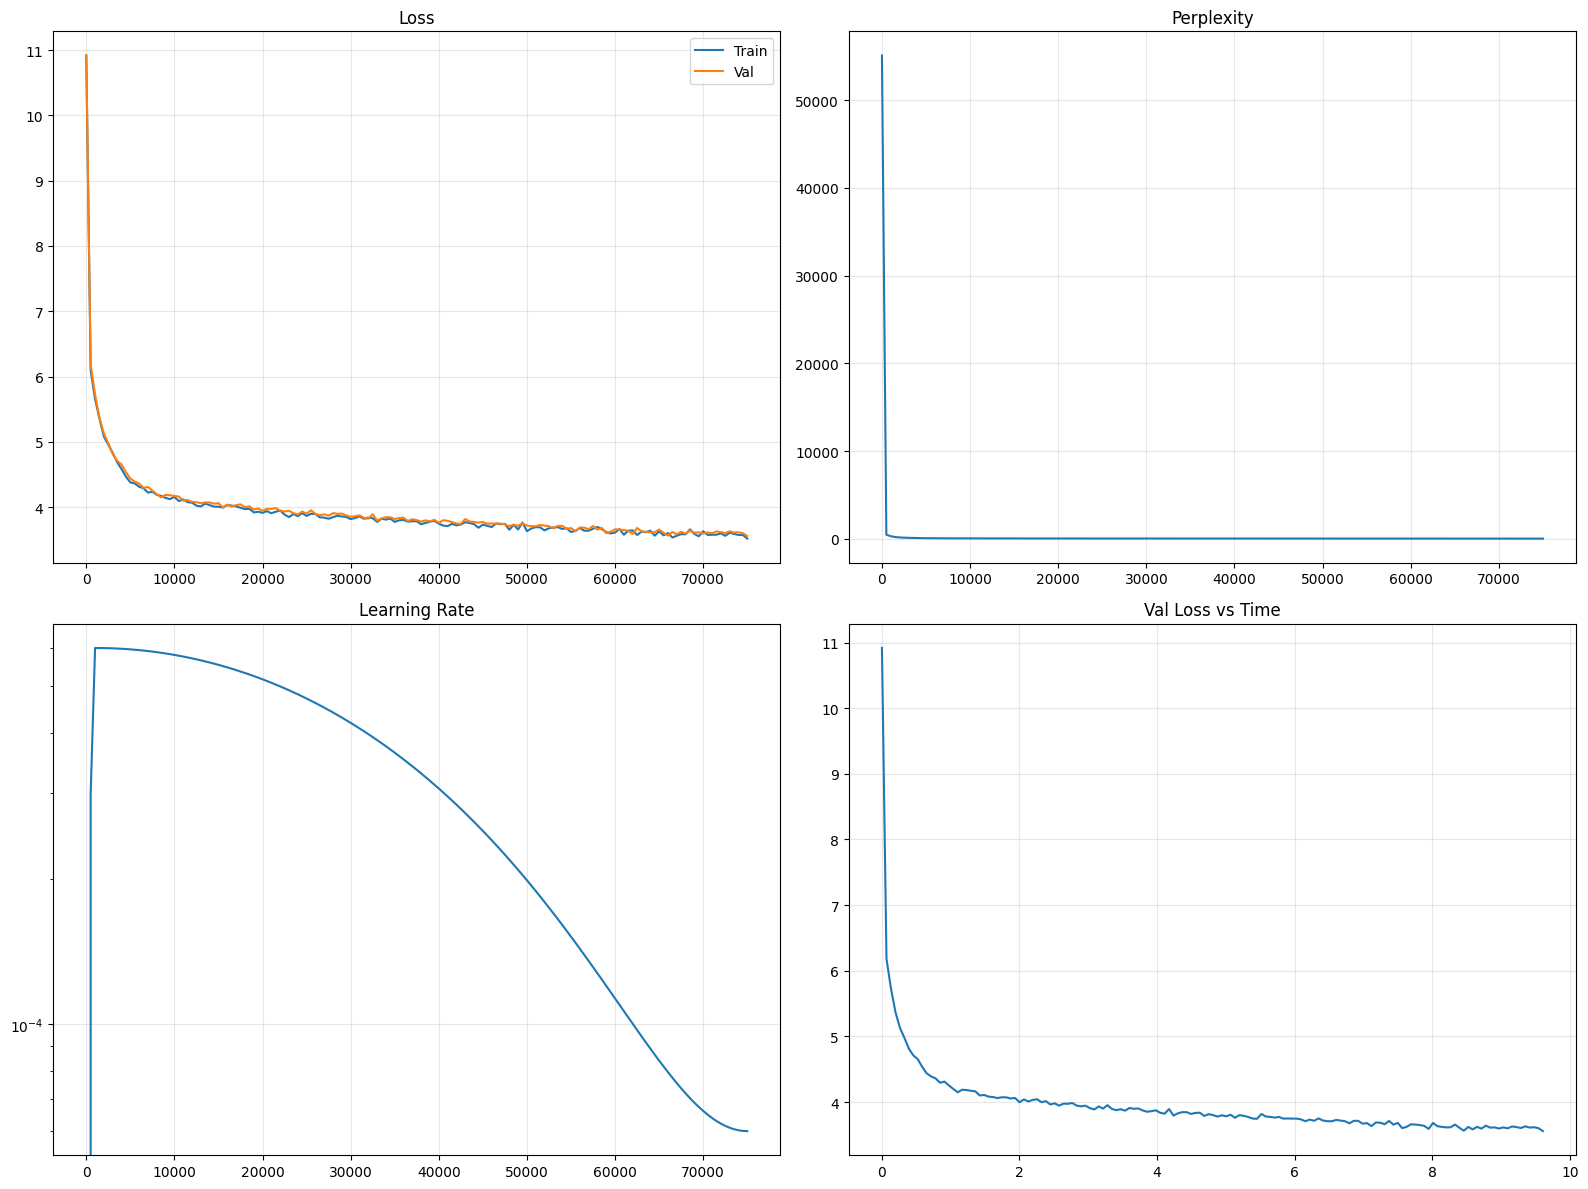

In [1]:
"""
SCRIPT 2: Train LatentGPT using memmap
--------------------------------------
- Uses wikipedia_tokens.bin + wikipedia_tokens_meta.json
- Samples random chunks from memmap (no full data in RAM)
"""

import os
import json
import math
import time
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
import matplotlib.pyplot as plt
from contextlib import nullcontext

# ============ CONFIG ============

# >>> UPDATE THESE PATHS according to how you added the memmap dataset <<<
# Example if you created a Kaggle dataset named "wikipedia-memmap"
MEMMAP_BIN_PATH = "/kaggle/input/jklu-en-memap-5gb/wikipedia_tokens.bin"
MEMMAP_META_PATH = "/kaggle/input/jklu-en-memap-5gb/wikipedia_tokens_meta.json"

# Model hyperparameters (smaller to avoid OOM)
n_embd = 512
n_head = 8
n_layer = 6
dropout = 0.1

# Training hyperparameters
batch_size = 8
block_size = 512
learning_rate = 6e-4
weight_decay = 0.1
grad_clip = 1.0
max_iters = 75000          # you can increase later
eval_interval = 500
eval_iters = 50
warmup_iters = 1000
gradient_accumulation_steps = 2
use_amp = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    try:
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    except Exception:
        pass

# ============ LOAD MEMMAP ============

print("\n" + "=" * 70)
print("LOADING MEMMAP DATASET")
print("=" * 70)

with open(MEMMAP_META_PATH, "r") as f:
    meta = json.load(f)

tokens_mem = np.memmap(
    MEMMAP_BIN_PATH,
    dtype=np.int32,
    mode="r",
)

n_tokens = tokens_mem.shape[0]
assert n_tokens == meta["n_tokens"], "Meta n_tokens mismatch with memmap length!"

split_idx = int(0.9 * n_tokens)
train_data = tokens_mem[:split_idx]
val_data = tokens_mem[split_idx:]

vocab_size = meta.get("vocab_size", 50257)  # fallback
print(f"Total tokens: {n_tokens:,}")
print(f"Train tokens: {len(train_data):,}")
print(f"Val tokens:   {len(val_data):,}")
print(f"Vocab size:   {vocab_size}")

# ============ BATCHING FUNCTION ============

def get_batch(split):
    """
    Sample a random batch of sequences from memmap.
    Returns x, y on the correct device.
    """
    data = train_data if split == "train" else val_data
    data_len = len(data)

    ix = torch.randint(0, data_len - block_size - 1, (batch_size,))
    x = torch.empty((batch_size, block_size), dtype=torch.long)
    y = torch.empty((batch_size, block_size), dtype=torch.long)

    for i in range(batch_size):
        start = int(ix[i])
        chunk = data[start : start + block_size + 1].astype(np.int64)
        x[i] = torch.from_numpy(chunk[:-1])
        y[i] = torch.from_numpy(chunk[1:])

    return x.to(device), y.to(device)

# ============ MODEL DEFINITIONS ============

class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    
    def forward(self, x):
        # RMS normalization across last dim
        rms = x.norm(dim=-1, keepdim=True) * (1.0 / math.sqrt(x.shape[-1]))
        return self.weight * (x / (rms + self.eps))

class LatentAttention(nn.Module):
    """
    Standard multi-head causal self-attention.
    Named LatentAttention so it’s easy to swap with GQA later.
    """
    def __init__(self, n_embd, n_head, dropout, block_size):
        super().__init__()
        assert n_embd % n_head == 0
        self.n_head = n_head
        self.head_dim = n_embd // n_head

        self.c_attn = nn.Linear(n_embd, 3 * n_embd)
        self.c_proj = nn.Linear(n_embd, n_embd)
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)

        mask = torch.tril(torch.ones(block_size, block_size)).view(1, 1, block_size, block_size)
        self.register_buffer("mask", mask)

    def forward(self, x):
        B, T, C = x.size()
        qkv = self.c_attn(x)
        q, k, v = qkv.split(C, dim=2)

        q = q.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_head, self.head_dim).transpose(1, 2)

        att = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float("-inf"))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)

        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y

class FeedForward(nn.Module):
    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.GELU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )
    
    def forward(self, x):
        return self.net(x)

class TransformerBlock(nn.Module):
    def __init__(self, n_embd, n_head, dropout, block_size):
        super().__init__()
        self.ln1 = RMSNorm(n_embd)
        self.ln2 = RMSNorm(n_embd)
        self.attn = LatentAttention(n_embd, n_head, dropout, block_size)
        self.ff = FeedForward(n_embd, dropout)
    
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        return x

class LatentGPT(nn.Module):
    def __init__(self):
        super().__init__()
        self.vocab_size = vocab_size
        self.block_size = block_size
        self.n_embd = n_embd
        
        self.tok_emb = nn.Embedding(self.vocab_size, n_embd)
        self.pos_emb = nn.Embedding(self.block_size, n_embd)
        self.drop = nn.Dropout(dropout)
        self.blocks = nn.ModuleList(
            [TransformerBlock(n_embd, n_head, dropout, block_size) for _ in range(n_layer)]
        )
        self.ln_f = RMSNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, self.vocab_size, bias=False)

        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    def forward(self, idx, targets=None):
        B, T = idx.shape
        if T > self.block_size:
            raise ValueError(f"Sequence length {T} > block_size {self.block_size}")

        pos = torch.arange(0, T, device=idx.device).unsqueeze(0)
        tok_emb = self.tok_emb(idx)
        pos_emb = self.pos_emb(pos)
        x = self.drop(tok_emb + pos_emb)

        for block in self.blocks:
            x = block(x)

        x = self.ln_f(x)
        logits = self.lm_head(x)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, self.vocab_size),
                targets.view(-1),
                ignore_index=-1,
            )
        return logits, loss

# ============ HELPER FUNCTIONS ============

def get_lr(iter_):
    if iter_ < warmup_iters:
        return learning_rate * iter_ / warmup_iters
    if iter_ > max_iters:
        return learning_rate * 0.1
    decay_ratio = (iter_ - warmup_iters) / (max_iters - warmup_iters)
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return learning_rate * 0.1 + coeff * (learning_rate - learning_rate * 0.1)

@torch.no_grad()
def estimate_loss(model, eval_iters, device):
    model.eval()
    losses = {"train": [], "val": []}
    ctx = torch.cuda.amp.autocast if (use_amp and device.type == "cuda") else nullcontext
    for split in ["train", "val"]:
        for _ in range(eval_iters):
            xb, yb = get_batch(split)
            with ctx():
                _, loss = model(xb, yb)
            losses[split].append(loss.item())
    out = {
        "train": sum(losses["train"]) / len(losses["train"]),
        "val": sum(losses["val"]) / len(losses["val"]),
    }
    model.train()
    return out

# ============ INITIALIZE MODEL ============

print("\n" + "=" * 70)
print("INITIALIZING MODEL")
print("=" * 70)

model = LatentGPT().to(device)
param_count = sum(p.numel() for p in model.parameters())
print(f"Parameters: {param_count/1e6:.2f}M")
print(f"Approx model size (fp32): {param_count * 4 / 1e6:.2f} MB")

# quick sanity: list first few named parameters
for i, (n, p) in enumerate(model.named_parameters()):
    if i < 10:
        print(n, tuple(p.shape))
    else:
        break

# ============ TRAINING SETUP ============

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay,
    betas=(0.9, 0.95),
)

scaler = torch.cuda.amp.GradScaler() if (use_amp and device.type == "cuda") else None
ctx = torch.cuda.amp.autocast if (use_amp and device.type == "cuda") else nullcontext

metrics = {
    "train_losses": [],
    "val_losses": [],
    "perplexities": [],
    "learning_rates": [],
    "iterations": [],
    "timestamps": [],
}

dirs = {
    "checkpoints": "/kaggle/working/checkpoints",
    "plots": "/kaggle/working/plots",
    "logs": "/kaggle/working/logs",
}
for name, path in dirs.items():
    os.makedirs(path, exist_ok=True)
    print(f"✅ {name.capitalize()} dir: {path}")

start_time = time.time()
best_val_loss = float("inf")

# ============ TRAINING LOOP ============

print("\n" + "=" * 70)
print("STARTING TRAINING")
print("=" * 70)

for step in range(max_iters):
    # Set LR
    lr = get_lr(step)
    for pg in optimizer.param_groups:
        pg["lr"] = lr

    # Evaluation
    if step % eval_interval == 0 or step == max_iters - 1:
        losses = estimate_loss(model, eval_iters, device)
        train_loss = losses["train"]
        val_loss = losses["val"]
        ppl = float(math.exp(val_loss))

        metrics["train_losses"].append(train_loss)
        metrics["val_losses"].append(val_loss)
        metrics["perplexities"].append(ppl)
        metrics["learning_rates"].append(lr)
        metrics["iterations"].append(step)
        metrics["timestamps"].append(time.time() - start_time)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            mark = " ⭐ BEST"
            torch.save(
                {
                    "step": step,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "val_loss": val_loss,
                },
                os.path.join(dirs["checkpoints"], "best_model.pt"),
            )
        else:
            mark = ""

        elapsed = time.time() - start_time
        eta = elapsed / (step + 1) * (max_iters - step - 1)
        print(
            f"Step {step:5d} | Train {train_loss:.4f} | Val {val_loss:.4f} | "
            f"PPL {ppl:8.2f} | LR {lr:.2e} | Elapsed {elapsed/3600:5.2f}h | ETA {eta/3600:5.2f}h{mark}"
        )

        if device.type == "cuda":
            torch.cuda.empty_cache()

    # Training step
    optimizer.zero_grad(set_to_none=True)

    for micro in range(gradient_accumulation_steps):
        xb, yb = get_batch("train")
        with ctx():
            _, loss = model(xb, yb)
            loss = loss / gradient_accumulation_steps

        if scaler is not None:
            scaler.scale(loss).backward()
        else:
            loss.backward()

    if scaler is not None:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        scaler.step(optimizer)
        scaler.update()
    else:
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

total_time = time.time() - start_time
print(f"\n✅ Training finished in {total_time/3600:.2f} hours")

# ============ SAVE METRICS & PLOTS ============

print("\nSaving metrics and plots...")

df = pd.DataFrame(
    {
        "iteration": metrics["iterations"],
        "train_loss": metrics["train_losses"],
        "val_loss": metrics["val_losses"],
        "perplexity": metrics["perplexities"],
        "learning_rate": metrics["learning_rates"],
        "time_hours": [t / 3600 for t in metrics["timestamps"]],
    }
)
csv_path = os.path.join(dirs["logs"], "training_metrics.csv")
df.to_csv(csv_path, index=False)
print(f"✅ Saved metrics to {csv_path}")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax = axes[0, 0]
ax.plot(metrics["iterations"], metrics["train_losses"], label="Train")
ax.plot(metrics["iterations"], metrics["val_losses"], label="Val")
ax.set_title("Loss")
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
ax.plot(metrics["iterations"], metrics["perplexities"])
ax.set_title("Perplexity")
ax.grid(True, alpha=0.3)

ax = axes[1, 0]
ax.plot(metrics["iterations"], metrics["learning_rates"])
ax.set_title("Learning Rate")
ax.set_yscale("log")
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
time_hours = [t / 3600 for t in metrics["timestamps"]]
ax.plot(time_hours, metrics["val_losses"])
ax.set_title("Val Loss vs Time")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plot_path = os.path.join(dirs["plots"], "training_results.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
print(f"✅ Saved plot to {plot_path}")

print("\nDone. Check /kaggle/working for checkpoints, logs and plots.")
